# Introduction
This notebook was written by Rafael Oliveira on 2024-07-009.

This project focuses on estimating zero-coupon rates for Brazilian government coupon-paying bonds, specifically NTN-Fs, from data available for LTNs (zero-coupon bonds) and NTN-Fs, using bootstrapping techniques.

1. **Data Collection:** Obtaining prices and expiration dates for LTNs and NTN-Fs.
2. **Zero-Coupon Rate Calculation:** Calculating zero-coupon rates directly from LTN prices.
3. **Bootstrapping:** Using a bootstrapping method to derive zero-coupon rates for NTN-Fs, considering their semi-annual coupon payments on January 1st and July 1st.
4. **Interpolation:** Implementing linear interpolation to discount the coupon payments accurately.

In [245]:
import pandas as pd
import xlrd
from datetime import date
from datetime import datetime
import numpy as np
from scipy.interpolate import interp1d

In [246]:
def get_bond_data_from_file(filepath: str):
    rename_columns_dict = {
        'Titulo': 'type',
        'Data Vencimento': 'maturity',
        'PU': 'price',
    }
    df_bonds = pd.read_csv(filepath, encoding='windows-1252', skiprows=2, delimiter='@', decimal =',')
    df_bonds = df_bonds[rename_columns_dict.keys()].rename(columns=rename_columns_dict)
    df_bonds['maturity'] = pd.to_datetime(df_bonds['maturity'], format='%Y%m%d')
    return df_bonds
df_bonds = get_bond_data_from_file('data/2024.01.07 - bonds.txt') 
df_ltn = df_bonds[df_bonds.type == 'LTN'].copy() 
df_ntnf = df_bonds[df_bonds.type == 'NTN-F'].copy() 
df_ntnf.head()

,type,maturity,price
40,NTN-F,2025-01-01,995.301420
41,NTN-F,2027-01-01,958.284225
42,NTN-F,2029-01-01,926.606633
43,NTN-F,2031-01-01,899.357893
44,NTN-F,2033-01-01,883.863587


In [247]:
# Create a list with Anbima holidays

# Open the workbook and select the first sheet
wb = xlrd.open_workbook("data/holidays_anbima.xls")
ws = wb.sheet_by_index(0)

# Initialize a list to hold holiday dates
holidays_anbima = []

# Iterate through the rows to extract holiday dates
i = 1
while ws.cell_type(i, 0) == 3:  # 3 indicates an Excel date cell
    y, m, d, _, _, _ = xlrd.xldate_as_tuple(ws.cell_value(i, 0), wb.datemode)
    holidays_anbima.append(date(y, m, d))
    i += 1

# Print the first and last 5 holidays to verify
print(holidays_anbima[:5])
print(holidays_anbima[-5:])

[datetime.date(2001, 1, 1), datetime.date(2001, 2, 26), datetime.date(2001, 2, 27), datetime.date(2001, 4, 13), datetime.date(2001, 4, 21)]
[datetime.date(2099, 10, 12), datetime.date(2099, 11, 2), datetime.date(2099, 11, 15), datetime.date(2099, 11, 20), datetime.date(2099, 12, 25)]


In [248]:
from datetime import timedelta


def adjust_to_business_day(date, holidays):
    while date.weekday() >= 5 or date.date() in holidays:  # Saturday=5, Sunday=6
        date += timedelta(days=1)
    return date

# Adjust maturities to the next business day if necessary
df_ltn['maturity'] = df_ltn['maturity'].apply(adjust_to_business_day, holidays=holidays_anbima)
df_ntnf['maturity'] = df_ntnf['maturity'].apply(adjust_to_business_day, holidays=holidays_anbima)
df_ltn

,type,maturity,price
0,LTN,2024-10-01,974.346516
1,LTN,2025-01-02,949.220451
2,LTN,2025-04-01,923.822349
3,LTN,2025-07-01,898.670214
4,LTN,2025-10-01,870.891655
5,LTN,2026-01-02,845.267940
6,LTN,2026-04-01,820.920618
7,LTN,2026-07-01,797.602220
8,LTN,2027-07-01,708.400561
9,LTN,2028-01-03,665.882563


In [249]:
def business_days_to_years(maturity, today, holidays):
    business_days = np.busday_count(today, maturity.date(), holidays=holidays)
    return business_days / 252

today = pd.to_datetime('2024-07-01').date()
df_ltn['years'] = df_ltn['maturity'].apply(lambda x: business_days_to_years(x, today, holidays_anbima))
df_ntnf['years'] = df_ntnf['maturity'].apply(lambda x: business_days_to_years(x, today, holidays_anbima))
df_ltn

,type,maturity,price,years
0,LTN,2024-10-01,974.346516,0.261905
1,LTN,2025-01-02,949.220451,0.511905
2,LTN,2025-04-01,923.822349,0.753968
3,LTN,2025-07-01,898.670214,0.996032
4,LTN,2025-10-01,870.891655,1.257937
5,LTN,2026-01-02,845.267940,1.511905
6,LTN,2026-04-01,820.920618,1.753968
7,LTN,2026-07-01,797.602220,1.996032
8,LTN,2027-07-01,708.400561,2.988095
9,LTN,2028-01-03,665.882563,3.496032


In [250]:
# Calculate zero-coupon rates for LTNs
def zero_coupon_rate(price, years):
    return (1000 / price) ** (1 / years) - 1
df_ltn['zero_coupon_rate'] = df_ltn.apply(lambda row: zero_coupon_rate(row['price'], row['years']), axis=1)
df_ltn

,type,maturity,price,years,zero_coupon_rate
0,LTN,2024-10-01,974.346516,0.261905,0.104318
1,LTN,2025-01-02,949.220451,0.511905,0.107167
2,LTN,2025-04-01,923.822349,0.753968,0.110812
3,LTN,2025-07-01,898.670214,0.996032,0.113229
4,LTN,2025-10-01,870.891655,1.257937,0.116158
5,LTN,2026-01-02,845.267940,1.511905,0.117602
6,LTN,2026-04-01,820.920618,1.753968,0.119077
7,LTN,2026-07-01,797.602220,1.996032,0.119965
8,LTN,2027-07-01,708.400561,2.988095,0.122292
9,LTN,2028-01-03,665.882563,3.496032,0.123350


In [251]:
def bootstrap_coupon_bond(df_ltn, df_ntnf, coupon_payment, holidays):
    # Create a DataFrame to hold the years and zero rates
    zero_curve_df = df_ltn[['years', 'zero_coupon_rate']].copy()
    today = pd.to_datetime('2024-07-01').date()
    
    for index, bond in df_ntnf.iterrows():
        price = bond['price']
        bond_years = bond['years']
        
        # Generate payment dates for coupons (January 1st and July 1st)
        payment_dates = []
        maturity_date = bond['maturity'].date()
        
        current_date = today
           
        while current_date < maturity_date:
            next_jan = adjust_to_business_day(datetime(current_date.year + 1, 1, 1), holidays).date()
            next_jul = adjust_to_business_day(datetime(current_date.year, 7, 1), holidays).date()
            if next_jan > current_date and next_jan < maturity_date:
                payment_dates.append(next_jan)
            if next_jul > current_date and next_jul < maturity_date:
                payment_dates.append(next_jul)
            current_date = next_jan
        
        payment_dates = sorted(payment_dates)
        
        pv_coupons = 0
        
        # Sort the zero_curve_df to ensure proper interpolation
        zero_curve_df = zero_curve_df.sort_values(by='years').reset_index(drop=True)
        
        # Create interpolation function for zero rates
        interpolate = interp1d(zero_curve_df['years'], zero_curve_df['zero_coupon_rate'], fill_value="extrapolate")
        
        if payment_dates:
            for date in payment_dates:
                coupon_time = np.busday_count(today, date, holidays=holidays) / 252
                discount_rate = interpolate(coupon_time)
                pv_coupons += coupon_payment / (1 + discount_rate) ** coupon_time
            
        remaining_cash_flow = price - pv_coupons
        final_payment = 1000 + coupon_payment
        bond_rate = (final_payment / remaining_cash_flow) ** (1 / bond_years) - 1
        
        # Append the new bond's rate to the zero_curve_df
        new_row = pd.DataFrame({'years': [bond_years], 'zero_coupon_rate': [bond_rate]})
        zero_curve_df = pd.concat([zero_curve_df, new_row], ignore_index=True)
        
        df_ntnf.loc[index, 'zero_coupon_rate'] = bond_rate

    return df_ntnf

In [252]:
# Apply bootstrapping
coupon_payment = 48.81
df_ntnf = bootstrap_coupon_bond(df_ltn, df_ntnf, coupon_payment, holidays_anbima)
df_ntnf

,type,maturity,price,years,zero_coupon_rate
40,NTN-F,2025-01-02,995.301420,0.511905,0.107711
41,NTN-F,2027-01-04,958.284225,2.500000,0.121218
42,NTN-F,2029-01-02,926.606633,4.480159,0.123754
43,NTN-F,2031-01-02,899.357893,6.468254,0.125263
44,NTN-F,2033-01-03,883.863587,8.468254,0.124076
45,NTN-F,2035-01-02,874.375374,10.448413,0.122658


In [253]:
df_futures = pd.read_csv('data/2024.01.07 - futures.csv')
df_futures.head()

,years,zero_coupon_rate
0,0.091270,10.428952
1,0.178571,10.481974
2,0.261905,10.540018
3,0.353175,10.611002
4,0.428571,10.710012


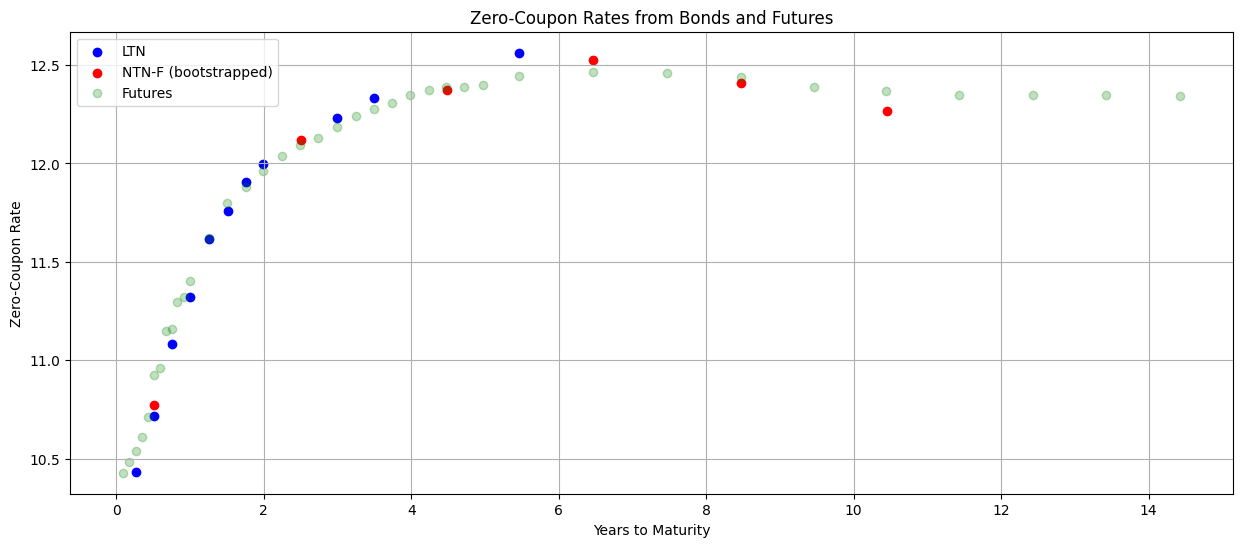

In [254]:
from matplotlib import pyplot as plt

# Plot the yield curve as a scatter plot with different colors for LTNs and NTN-Fs
plt.figure(figsize=(15, 6))
plt.scatter(df_ltn['years'], df_ltn['zero_coupon_rate']*100, color='blue', label='LTN')
plt.scatter(df_ntnf['years'], df_ntnf['zero_coupon_rate']*100, color='red', label='NTN-F (bootstrapped)')
plt.scatter(df_futures['years'], df_futures['zero_coupon_rate'], color='green', label='Futures', alpha=0.25)
plt.xlabel('Years to Maturity')
plt.ylabel('Zero-Coupon Rate')
plt.title('Zero-Coupon Rates from Bonds and Futures')
plt.legend()
plt.grid(True)
plt.show()